Material for the book [Probability and Statistics for Data Science](https://a.co/d/cAss9mO). A free preprint, videos, code, slides and solutions to exercises are available at https://www.ps4ds.net/

Code for Figures 6.2 and 6.5

Analysis of hourly precipitation and temperature data from 2015 in Mauna Loa (Hawaii)\
Topics and relevant videos: [Joint distribution of discrete and continuous variables, marginal distributions, conditional distributions](https://www.youtube.com/watch?v=DQxf2t_OM-8), [kernel density estimation](https://www.youtube.com/watch?v=TxB-rbrXMys)

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from scipy import stats

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"
file_name_precipitation_2015 = "../data/weather/precipitation_2015.npy"

temperature_matrix = np.load(file_name_temperature_2015)
precipitation_matrix = np.load(file_name_precipitation_2015)

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [14]:
stations = [45] 
for station in stations:
    name = process_name(file_name_list[station])# list starts at 1
    print(name) 

MaunaLoa, HI


In [15]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("Entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
temperature = {}
precipitation = {}
for station in stations:
    temperature[station] = remove_faulty_measurements(temperature_matrix[:,station],verbose)
    precipitation_aux = remove_faulty_measurements(precipitation_matrix[:,station],verbose)
    precipitation[station] = np.zeros(len(precipitation_aux))
    precipitation[station][precipitation_aux > 0] = 1

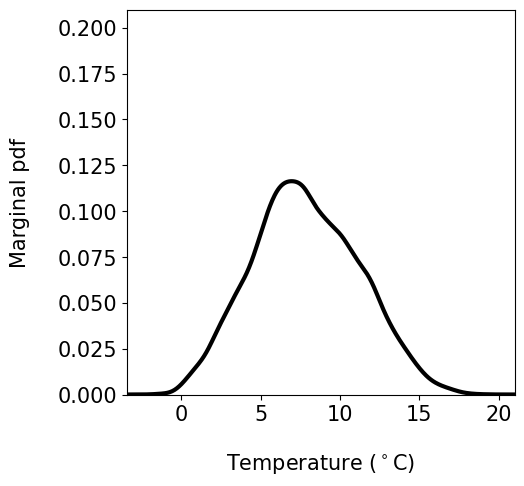

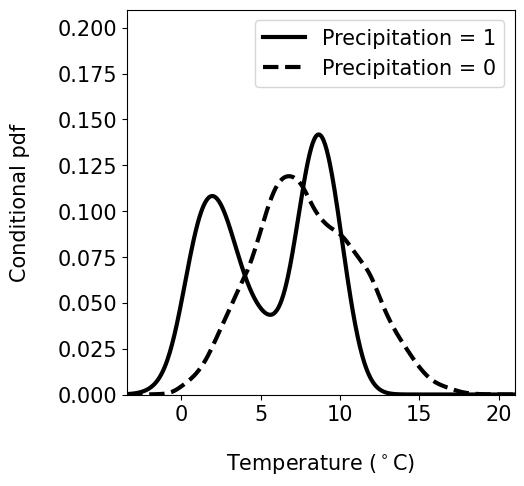

In [16]:
# We estimate the conditional pdf of temperature given precipitation using kernel density estimation
def KDE_1D(data,x,bw=None):
    kernel = stats.gaussian_kde(data,bw_method=bw)
    kde = kernel(x)
    return kde

y_max = 0.21

bw_vals = [0.15]
bw_vals_1 = [0.3] # There is less data when we condition, so we use a larger bandwidth
for station in stations:
    tmin = temperature[station].min()-2
    tmax = temperature[station].max()+2
    t = np.linspace(tmin,tmax,500)

    for index,bw in enumerate(bw_vals):
        bw_1 = bw_vals_1[index]
        kde_temperature = KDE_1D(temperature[station],t,bw=bw)
        kde_temperature_1 = KDE_1D(temperature[station][precipitation[station]==1],t,bw=bw_1)
        kde_temperature_0 = KDE_1D(temperature[station][precipitation[station]==0],t,bw=bw)

        plt.figure(figsize=(5,5))
        plt.xticks([0,5,10,15,20,25,30],fontsize=font_size_ticks) 
        plt.yticks(fontsize=font_size_ticks)
        plt.plot(t,kde_temperature,color="black",lw=3)
        plt.xlim([tmin,tmax])
        plt.ylim([0,y_max])
        plt.ylabel(r"Marginal pdf",fontsize=font_size,labelpad = 5)
        plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad = 5)
        
        plt.figure(figsize=(5,5))
        plt.xticks([0,5,10,15,20,25,30],fontsize=font_size_ticks) 
        plt.yticks(fontsize=font_size_ticks)
        plt.plot(t,kde_temperature_1,color="black",lw=3,label="Precipitation = 1")
        plt.plot(t,kde_temperature_0,color="black",lw=3,ls="dashed",label="Precipitation = 0")
        plt.xlim([tmin,tmax])
        plt.ylim([0,y_max])
        plt.ylabel(r"Conditional pdf",fontsize=font_size,labelpad = 5)
        plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad = 5)
        plt.legend(fontsize=font_size);        

Probability of precipitation 0.036


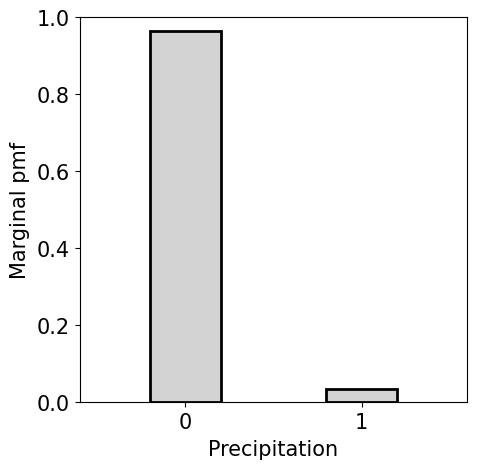

In [17]:
xmin = -0.6
xmax = 1.6
vals = [0,1]
ymax = 1
for station in stations:
    p_1 = float(np.count_nonzero(precipitation[station] == 1)) / float(len(precipitation[station]))
    marginal_pmf = [1-p_1,p_1]
    print("Probability of precipitation",round(p_1,3))

    plt.figure(figsize=(5,5))
    plt.bar(vals,marginal_pmf, width = 0.4, color = "lightgray", edgecolor="black",linewidth = 2)
    plt.xticks(np.arange(0, 1+1, 1))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.ylim([0,ymax])
    plt.xlim([xmin,xmax])
    plt.ylabel("Marginal pmf",fontsize=font_size,labelpad = 5)
    plt.xlabel("Precipitation",fontsize=font_size,labelpad = 5);

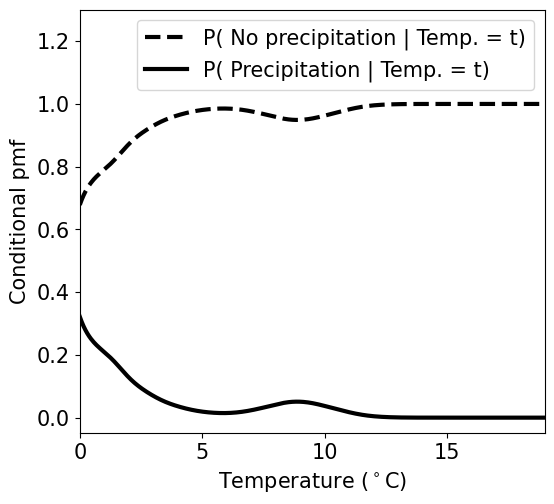

In [24]:
for station in stations:
    tmin = max(temperature[station].min(),0)
    tmax = temperature[station].max()
    t = np.linspace(tmin,tmax,500)
    bw_vals = [0.15] # [0.05,0.15,0.3]
    bw_vals_1 = [0.3] # [0.1,0.3,0.5]
    for index,bw in enumerate(bw_vals):
        bw_1 = bw_vals_1[index]
        kde_temperature = KDE_1D(temperature[station],t,bw=bw)
        kde_temperature_1 = KDE_1D(temperature[station][precipitation[station]==1],t,bw=bw_1)
        kde_temperature_0 = KDE_1D(temperature[station][precipitation[station]==0],t,bw=bw)

        precipitation_given_temperature_1 = kde_temperature_1 * p_1 / kde_temperature
        precipitation_given_temperature_0 = 1-precipitation_given_temperature_1

        plt.figure(figsize=(6,5.5))
        plt.xticks([0,5,10,15,20,25,30],fontsize=font_size_ticks) 
        plt.yticks(fontsize=font_size_ticks)
        #sns.kdeplot(temperature_1,bw=bw,color="black",lw=3,gridsize=1000, legend = False)#,color='white', edgecolor='black',linewidth=2)
        plt.plot(t,precipitation_given_temperature_0,color="black",lw=3,ls="dashed",label='P( No precipitation | Temp. = t)')
        plt.plot(t,precipitation_given_temperature_1,color="black",lw=3,label='P( Precipitation | Temp. = t)')
        plt.xlim([tmin,tmax])
        plt.ylim([-0.05,1.3])
        plt.ylabel(r"Conditional pmf",fontsize=font_size,labelpad = 5)
        plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad = 5)
        plt.legend(fontsize=font_size);        